In [1]:
from Bending.FullBending import FullBending
import numpy as np
import pandas as pd

In [2]:
# E [GPa]
# nucleo	4.22
# X	26.95
# SX	13.57
# Y	97.86
# SY	4.22

df_layers = pd.DataFrame({ 'E': [5.93,
                                 7.84, 
                                 5.93, 
                                 15.22, 
                                 6.06]}, index=['nucleo', 'X', 'SX', 'Y', 'SY'])

In [3]:
df_layers

,E
nucleo,5.93
X,7.84
SX,5.93
Y,15.22
SY,6.06


In [4]:
composition = [
        ["Y", "Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y","SX","SY"],
        ["Y","X", "SY"]
    ]


In [5]:
df_data = pd.read_csv("experimental.csv")
df_data["Modulo flexion [GPa]"] =  df_data["Modulo flexion [MPa]"]/1000
df_data = df_data.drop(columns=["Modulo flexion [MPa]"])
df_data = df_data.drop(columns=["Tension maxima [MPa]"])
df_data["Espesor [mm]"] = 0.5*df_data["Espesor [mm]"] + 0.5*df_data["Espesor_2 [mm]"]
df_data = df_data.drop(columns=["Espesor_2 [mm]"])

# 
#  Ancho [mm]-> B [mm]
#  Espesor [mm] -> t [mm]
#  Modulo flexion [MPa] -> E [GPa]

df_data["B [mm]"] = df_data["Ancho [mm]"]
df_data["t [mm]"] = df_data["Espesor [mm]"]
df_data["E [GPa]"] = df_data["Modulo flexion [GPa]"]

df_data = df_data.drop(columns=["Ancho [mm]"])
df_data = df_data.drop(columns=["Espesor [mm]"])
df_data = df_data.drop(columns=["Modulo flexion [GPa]"])

df_stats = df_data.groupby('Nombre').agg(['mean', 'std'])
df_stats["layers"] = composition



In [6]:
df_stats

B [mm]              t [mm]              E [GPa]            \
             mean       std      mean       std       mean       std   
Nombre                                                                 
TFP1-1  25.600000  0.100000  5.100000  0.000000  13.201050  0.630858   
TFP2-1  25.566667  0.057735  4.600000  0.050000   9.869501  0.780113   
TFP3-1  25.400000  0.173205  4.866667  0.076376   9.222003  0.495965   
TFP4-1  25.666667  0.152753  4.600000  0.000000  10.181815  0.770635   
TFP5-1  25.166667  0.152753  5.716667  0.057735   6.143105  0.161637   
TFP6-1  25.033333  0.635085  5.566667  0.028868   7.798060  0.334186   

             layers  
                     
Nombre               
TFP1-1       [Y, Y]  
TFP2-1       [Y, X]  
TFP3-1      [Y, SX]  
TFP4-1      [Y, SY]  
TFP5-1  [Y, SX, SY]  
TFP6-1   [Y, X, SY]

In [7]:

import os 
from copy import deepcopy
join = os.path.join

E_pred = []

if not os.path.exists("output"):
    os.mkdir("output")

params = {
            "geo" : {
                        "t_n" : 2.51,
                        "t_l" : 0.5,
                        "Lx"  : 30,
                    },
            "sim" : {
                        "disp" : 0.5,
                    },
        }


all_params = []
for id_design in range(6):
    E_n =   df_layers.loc["nucleo"].values[-1]*1e3

    lyrs = df_stats["layers"].iloc[id_design]

    E_l = df_layers.loc[lyrs]["E"].values*1e3 # MPa
    name_mat = df_stats["layers"].iloc[id_design]
    name = df_stats.index[id_design]
    B    = df_stats["B [mm]"]["mean"].iloc[id_design]

    params_loop = deepcopy(params)

    B = 25
    params_loop["geo"]["Ly"] = B
    params_loop["sim"]["E_n"] = E_n
    params_loop["sim"]["E_l"] = E_l
    params_loop["sim"]["name_mat"] = name_mat
    params_loop["output_folder"] = join("output", name)

    print(params)
    inp_f = FullBending(params_loop)
    Eflex = params_loop["Eflex"]

    E_pred.append(Eflex)
    all_params.append(params_loop)

{'geo': {'t_n': 2.51, 't_l': 0.5, 'Lx': 30}, 'sim': {'disp': 0.5}}
Running Calculix at:  output\TFP1-1\sim
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite\scripts\T02_BendingTest\NumericalModel\output\TFP1-1\sim\out.txt
Command:
 mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  4576 

Calculix finished

{'geo': {'t_n': 2.51, 't_l': 0.5, 'Lx': 30}, 'sim': {'disp': 0.5}}
Running Calculix at:  output\TFP2-1\sim
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite\scripts\T02_BendingTest\NumericalModel\output\TFP2-1\sim\out.txt
Command:
 mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  12036 

Calculix finished

{'geo': {'t_n': 2.51, 't_l': 0.5, 'Lx': 30}, 'sim': {'disp': 0.5}}
Running Calculix at:  output\TFP3-1\sim
Output file:  c:\Users\djoroya\Documen

In [8]:
df_stats["E pred [GPa]"] = E_pred

tau_pred  = [ iall_params["geo"]["t_t"] for iall_params in all_params]
B_span   = [ iall_params["geo"]["Ly"] for iall_params in all_params]
df_stats["t pred [mm]"] = tau_pred
df_stats["B [mm]"] = B_span

In [9]:
df_stats

B [mm]        t [mm]              E [GPa]                 layers  \
         mean std      mean       std       mean       std                
Nombre                                                                    
TFP1-1     25  25  5.100000  0.000000  13.201050  0.630858       [Y, Y]   
TFP2-1     25  25  4.600000  0.050000   9.869501  0.780113       [Y, X]   
TFP3-1     25  25  4.866667  0.076376   9.222003  0.495965      [Y, SX]   
TFP4-1     25  25  4.600000  0.000000  10.181815  0.770635      [Y, SY]   
TFP5-1     25  25  5.716667  0.057735   6.143105  0.161637  [Y, SX, SY]   
TFP6-1     25  25  5.566667  0.028868   7.798060  0.334186   [Y, X, SY]   

       E pred [GPa] t pred [mm]  
                                 
Nombre                           
TFP1-1    13.866182        4.51  
TFP2-1    10.011739        4.51  
TFP3-1     8.991418        4.51  
TFP4-1     9.061292        4.51  
TFP5-1     7.602355        5.51  
TFP6-1     8.143301        5.51

In [10]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Modulo Flexión [GPa]')

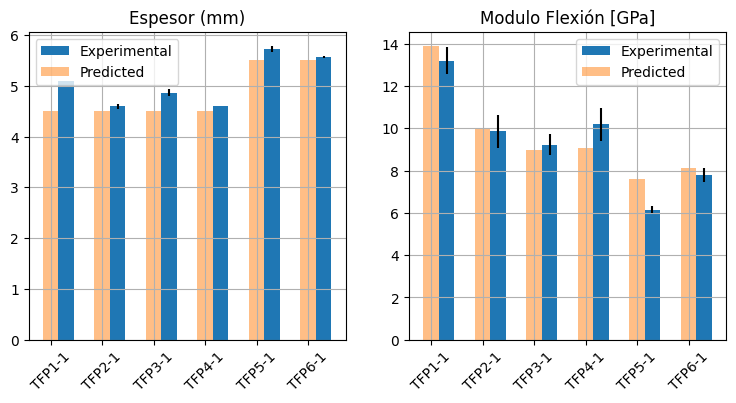

In [11]:
# plot bars with error bars Espesor (mm)
width = 0.3
idx = df_stats.index
idx_range = np.arange(len(idx))

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)

plt.bar(idx_range+width , df_stats['t [mm]']['mean'], yerr=df_stats['t [mm]']['std'], label='Experimental',width=width)
plt.bar(idx_range, tau_pred, label='Predicted', alpha=0.5, width=width)
plt.title('Espesor (mm)')

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('') 
plt.grid()
plt.xticks(idx_range, idx);

ax = fig.add_subplot(122)

# plot bars with error bars Modulo Tracción [MPa] and prediction

plt.bar(idx_range+width , df_stats['E [GPa]']['mean'], yerr=df_stats['E [GPa]']['std'], label='Experimental',width=width)
plt.bar(idx_range, df_stats['E pred [GPa]'], label='Predicted', alpha=0.5, width=width)
plt.legend()
plt.grid()
# off xlabel
plt.xlabel('') 
plt.xticks(rotation=45)
# tick labels 
plt.xticks(idx_range, idx);

plt.title('Modulo Flexión [GPa]')

In [12]:
df_stats

B [mm]        t [mm]              E [GPa]                 layers  \
         mean std      mean       std       mean       std                
Nombre                                                                    
TFP1-1     25  25  5.100000  0.000000  13.201050  0.630858       [Y, Y]   
TFP2-1     25  25  4.600000  0.050000   9.869501  0.780113       [Y, X]   
TFP3-1     25  25  4.866667  0.076376   9.222003  0.495965      [Y, SX]   
TFP4-1     25  25  4.600000  0.000000  10.181815  0.770635      [Y, SY]   
TFP5-1     25  25  5.716667  0.057735   6.143105  0.161637  [Y, SX, SY]   
TFP6-1     25  25  5.566667  0.028868   7.798060  0.334186   [Y, X, SY]   

       E pred [GPa] t pred [mm]  
                                 
Nombre                           
TFP1-1    13.866182        4.51  
TFP2-1    10.011739        4.51  
TFP3-1     8.991418        4.51  
TFP4-1     9.061292        4.51  
TFP5-1     7.602355        5.51  
TFP6-1     8.143301        5.51

In [13]:
df_save = pd.DataFrame({"E [GPa]": df_stats['E [GPa]']['mean'].values,
                        "E pred [GPa]": df_stats['E pred [GPa]'].values,
                        "Name": df_stats.index})

df_save.to_csv("output.csv", index=False)